### 📊 Ovis2-4B multimodal timing experiment

- **Ovis2-4B** is a **multimodal large language model (MLLM)** has size **4.62 B params** combines a **qwen2.5-3B as an LLM** and **AIMv2 Huge as vision encoder** and a special **visual embedding table**.

- It is higher performant than even some 7B>= large models <=10.

- It has features like **Video and Multi-Image Processing** also **Multilingual Support and OCR**.

- **Benchmark scores of Ovis2-4B** from **opencompass**: 
### 🔍 Ovis2-4B Performance Overview

| Benchmark | Score | Notes |
|----------|-------|--------|
| **OCRBench** | **911** | Highest among all <5B models |
| **MMBench-V1.1** | **81.4** | Strong general understanding |
| **HallusionBench** | **53.8** | Moderate hallucination |
| **MMVet** | **65.5** | Good image captioning quality |
| **RealWorldQA** | **71.1** | Works well on real-world images |
| **AI2D** | **85.7** | Understands structured visuals |
| **MathVista-Mini** | **69.6** | Solid math & logical reasoning |
| **SEEDBench_IMG** | **69.3** | Supports complex reasoning tasks |
| **MMT-Bench_VAL** | **65.2** | Follows instructions well |
| **SEEDBench2_Plus** | **53.1** | Handles advanced multimodal questions |

🧠 Ovis2-4B combines a **Qwen2.5-3B** language model with an **AIMv2 Huge** vision encoder, achieving state-of-the-art results among open-source MLLMs under 5B parameters. It excels at **text-heavy tasks** like meme caption detection due to its structural alignment between visual and textual embeddings.
=> This notebook benchmarks the inference time of different parts of the ovis2-4B image captioning pipeline to help us identfy where latency is concentrated.

In [20]:
# import modules
import torch
import time
from PIL import Image
from transformers import AutoModelForCausalLM
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# load Ovis2-4B model
model = AutoModelForCausalLM.from_pretrained("AIDC-AI/Ovis2-4B",torch_dtype=torch.bfloat16,multimodal_max_length=32768,trust_remote_code=True).cuda()
text_tokenizer = model.get_text_tokenizer()
visual_tokenizer = model.get_visual_tokenizer()

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  9.37it/s]


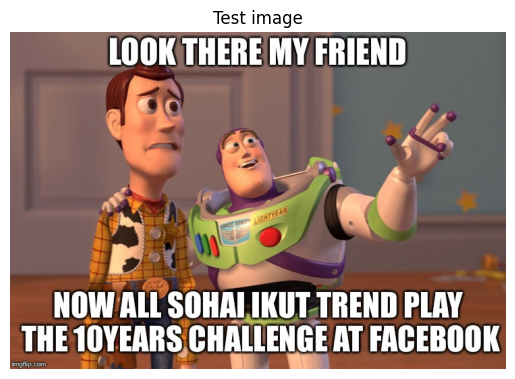

In [3]:
# load test image
img_path = "../data/images/image_1.jpg"
img = Image.open(img_path)
plt.imshow(img)
plt.title("Test image")
plt.axis("off")
plt.show()
images = [Image.open(img_path)]
max_partition = 9
text = 'Describe the image.'
query = f'<image>\n{text}'

In [4]:
# Check device
print("Is CUDA available?", torch.cuda.is_available())
print("Current device:", torch.cuda.get_device_name(0))
print("Model device:", next(model.parameters()).device)

Is CUDA available? True
Current device: NVIDIA GeForce RTX 4060
Model device: cuda:0


In [5]:
# preprocess input 
prompt, input_ids, pixel_values = model.preprocess_inputs(query, images, max_partition=max_partition)

In [6]:
# set device and dtype
model_dtype = next(visual_tokenizer.backbone.parameters()).dtype
device = next(visual_tokenizer.backbone.parameters()).device
pixel_values = pixel_values.to(dtype=model_dtype, device=device)

# vision encoder inference
start_vision = time.time()
visual_embeddings = visual_tokenizer.backbone(pixel_values)
end_vision = time.time()

vision_time = end_vision - start_vision
print(f"✅ Vision Encoder time: {vision_time:.2f} seconds")

✅ Vision Encoder time: 1.38 seconds


In [7]:
# attention mask
attention_mask = torch.ne(input_ids, text_tokenizer.pad_token_id)
input_ids = input_ids.unsqueeze(0).to(model.device)
attention_mask = attention_mask.unsqueeze(0).to(model.device)

# pixel values to expected format
pixel_values = [pixel_values]

# LLM caption generation
gen_kwargs = dict(
    max_new_tokens=1024,
    do_sample=False,
    top_p=None,
    top_k=None,
    temperature=None,
    repetition_penalty=None,
    eos_token_id=model.generation_config.eos_token_id,
    pad_token_id=text_tokenizer.pad_token_id,
    use_cache=True
)

start_caption = time.time()
with torch.inference_mode():
    output_ids = model.generate(
        input_ids, pixel_values=pixel_values, attention_mask=attention_mask, **gen_kwargs
    )[0]
end_caption = time.time()

caption_time = end_caption - start_caption
output = text_tokenizer.decode(output_ids, skip_special_tokens=True)

print(f"✅ Caption Generation time: {caption_time:.2f} seconds")
print("Generated Caption:\n", output)


✅ Caption Generation time: 54.42 seconds
Generated Caption:
 The image features two beloved characters from the Toy Story franchise: Woody and Buzz Lightyear. Woody, on the left, is dressed in his iconic yellow plaid shirt with a cowhide vest, looking concerned. Buzz Lightyear, on the right, is in his space suit, pointing excitedly with his right hand.

The background is a simple room with a blue wall adorned with yellow stars, creating a playful atmosphere. The text at the top reads "LOOK THERE MY FRIEND," while the text at the bottom states "NOW ALL SOHAI IKUT TREND PLAY THE 10YEARS CHALLENGE AT FACEBOOK."

This meme combines the classic Toy Story characters with a modern social media trend, creating a humorous juxtaposition. The image is from imgflip.com, as indicated by the watermark in the bottom left corner.


In [8]:
total_time = vision_time + caption_time
print("------------Summary------------")
print(f"Vision Encoder + Visual Embedding Table time: {vision_time:.2f} seconds")
print(f"Caption generation (LLM) time: {caption_time:.2f} seconds")
print(f"🔍 Total inference time: {total_time:.2f} seconds")


------------Summary------------
Vision Encoder + Visual Embedding Table time: 1.38 seconds
Caption generation (LLM) time: 54.42 seconds
🔍 Total inference time: 55.80 seconds


In [10]:
llm_percentage = caption_time / total_time * 100
ve_vet_percentage = vision_time / total_time * 100
print(f"LLM inference time : {llm_percentage:.2f}% of total inference time")
print(f"Vision encoder + VET inference time : {ve_vet_percentage:.2f}% of total inference time")

LLM inference time : 97.52% of total inference time
Vision encoder + VET inference time : 2.48% of total inference time


In [14]:
# run times from 5 runs
vision_times = [6.26, 2.13, 1.88, 1.65, 1.38]
caption_times = [55.79, 59.42, 51.07, 54.23, 54.42]
total_times = [62.05, 61.55, 52.96, 55.87, 55.80]


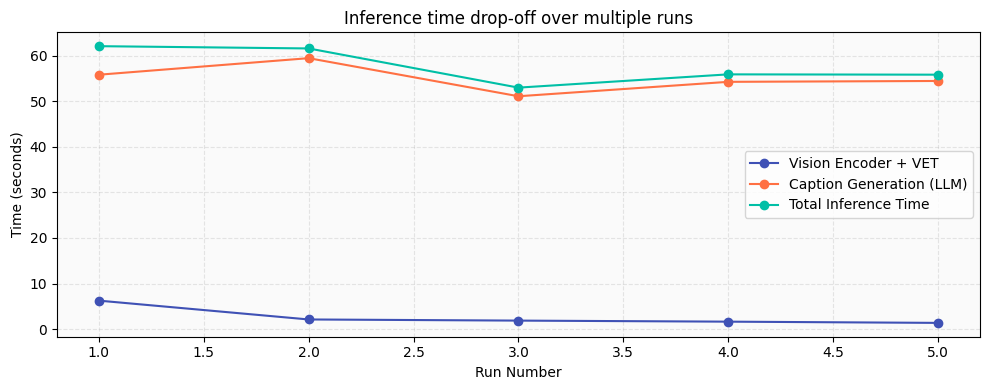

In [ ]:
plt.figure(figsize=(10, 4))
runs = [1, 2, 3, 4, 5]
plt.plot(runs, vision_times, marker='o', color='#3F51B5', label='Vision Encoder + VET')
plt.plot(runs, caption_times, marker='o', color='#FF7043', label='Caption Generation (LLM)')
plt.plot(runs, total_times, marker='o', color='#00BFA6', label='Total Inference Time')
plt.xlabel("Run Number")
plt.ylabel("Time (seconds)")
plt.title("Inference time drop-off over multiple runs")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.gca().set_facecolor('#FAFAFA')
plt.tight_layout()
plt.show()


In [24]:
avg_vision = np.mean(vision_times[1:])
avg_caption = np.mean(caption_times[1:])
avg_total = np.mean(total_times[1:])
llm_perc = (avg_caption / avg_total) * 100
vision_perc = (avg_vision / avg_total) * 100
print(f"✅ Average Vision Encoder + Visual Embedding Table time after warmup: {avg_vision:.2f} seconds")
print(f"✅ Average Caption generation (LLM) time: {avg_caption:.2f} seconds")
print(f"✅Average Total inference time: {avg_total:.2f} seconds")
print(f"✅ Average LLM inference time : {llm_perc:.2f}% of total inference time")
print(f"✅Average Vision encoder + VET inference time : {vision_perc:.2f}% of total inference time")

✅ Average Vision Encoder + Visual Embedding Table time after warmup: 1.76 seconds
✅ Average Caption generation (LLM) time: 54.78 seconds
✅Average Total inference time: 56.55 seconds
✅ Average LLM inference time : 96.89% of total inference time
✅Average Vision encoder + VET inference time : 3.11% of total inference time


**Note:** inference time measurements exclude the first run due to **CUDA warm-up effects** reported averages are computed over **runs 2-5** to reflect true performance

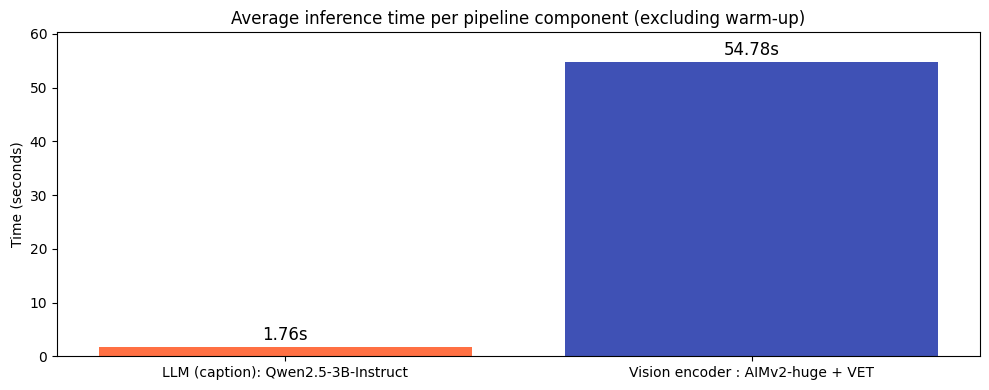

In [27]:
plt.figure(figsize=(10, 4))
labels = ['LLM (caption): Qwen2.5-3B-Instruct', 'Vision encoder : AIMv2-huge + VET']
times = [avg_vision, avg_caption]
colors = ['#FF7043', '#3F51B5']
bars = plt.bar(labels, times, color=colors)
plt.ylabel('Time (seconds)')
plt.title("Average inference time per pipeline component (excluding warm-up)")
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.5, f'{height:.2f}s', ha='center', va='bottom', fontsize=12)
plt.ylim(0, max(times)*1.1)
plt.tight_layout()
plt.show()

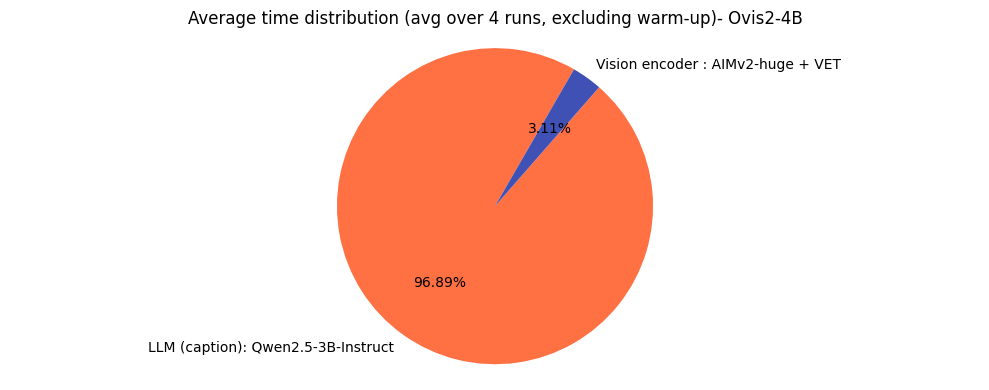

In [28]:
plt.figure(figsize=(10, 4))
labels_pie = ['LLM (caption): Qwen2.5-3B-Instruct', 'Vision encoder : AIMv2-huge + VET']
sizes = [llm_perc, vision_perc]
plt.pie(sizes, labels=labels_pie, colors= colors, startangle=60, autopct='%1.2f%%')
plt.axis('equal')
plt.title('Average time distribution (avg over 4 runs, excluding warm-up)- Ovis2-4B')
plt.tight_layout()
plt.show()

### 📑 Conclusion and insights
📌 Why time change between runs ?
- the first run typically takes extra time due to CUDA warm-up but subsequent runs are faster and this is a normal behavior on CUDA enabled systems like **NVIDIA GPUS**


📈 After averaging inference times over **5 consecutive runs** (excluding warm-up) we observed:

- **Average Vision Encoder + Visual Embedding Table inference time**: **1.76s**
- **AverageCaption Generation (LLM) inference time**: **54.78 seconds**
- **Average Total inference time**: **56.55 seconds**

### 📊 Insight:
- **96.89%** of the latency is due to the large LLM (**Qwen2.5-3B-Instruct**)
- The **Vision Encoder + Visual Embedding Table** accounts only accounts for **3.11%**

### 💡Decision:
To optimize the low latency while keeping high accuracy captioning:
- Keep the powerful AIMv2 Huge vision encoder and visual embedding table of OVIS2-4B (which drive image understanding, OCR and reasoning performance)

- Try to optimize the model.


=> This timing experiment provides clear evidence supporting future optimization.